# Trope media scanner v 1.0

don't forget to put hyperlinks and stuff

# Contents

# Table of Contents
0. [Introduction](#introduction)
   1. [What is TVTropes?](#a-what-is-tvtropes)
   2. [Problem Statement](#b-problem-statement)
   3. [Goal](#c-goal)
1. [Data Importation](#data-importation)
    1. [Imports (libraries)](#1-imports-libraries)
    2. [Scraping Episodes](#2-scraping-episodes)
    3. [Scraping Tropes](#3-scraping-tropes)
    4. [Trope/Wiki compiling](#4-tropewiki-compiling)
2. [Exploratory Data Analysis](#exploratory-data-analysis)

# 0 - Introduction 

## A. What is TVTropes?

TV Tropes is a wiki website that collects and describes common plot devices, character archetypes, and other storytelling elements. It is a valuable resource for writers, filmmakers, and other storytellers, as well as fans of popular culture who want to learn more about the stories they love. Some examples of tropes that are covered on TV Tropes include [the Hero's Journey](https://tvtropes.org/pmwiki/pmwiki.php/Main/TheHerosJourney), [Chekhov's Gun](https://tvtropes.org/pmwiki/pmwiki.php/Main/ChekhovsGun), and [Coming of Age story](https://tvtropes.org/pmwiki/pmwiki.php/Main/ComingOfAgeStory).

## B. Problem Statement

Identifying tropes in creative works can be a time-consuming and challenging task, especially for long or complex works. This can make it difficult for writers, filmmakers, and other storytellers to identify and use tropes effectively, and to avoid clichés. Additionally, fans of popular culture may have difficulty learning more about the tropes used in their favorite stories.

A trope scanner can help to solve this problem by automating the process of identifying tropes in creative works. This can save writers, filmmakers, and other storytellers a significant amount of time, and can help them to create more engaging and original stories. Additionally, a trope scanner can make it easier for fans of popular culture to learn more about the tropes used in their favorite stories.

Here are some specific examples of how a trope scanner can be used:
- A writer can use a trope scanner to identify and use tropes effectively in their work. For example, a writer could use a trope scanner to find examples of the Hero's Journey trope in popular movies, and then use those examples to inform their own writing.
- A filmmaker can use a trope scanner to identify and avoid clichés in their films. For example, a filmmaker could use a trope scanner to find examples of the [Deus ex Machina](https://tvtropes.org/pmwiki/pmwiki.php/Main/DeusExMachina) trope, and then avoid using that trope in their own films.
- A fan of popular culture can use a trope scanner to learn more about the tropes used in their favorite stories. For example, a fan of superhero movies could use a trope scanner to find examples of the [Secret Identity](https://tvtropes.org/pmwiki/pmwiki.php/Main/SecretIdentity) trope, and then learn more about the history and significance of that trope.

## C. Goal

The ultimate aim of this project is to create a bot that can populate a TVTropes wiki article with a serviceable first draft for a new piece of media. To do this, this bot needs to do the following:

A. Ingest some media <br>
B. Create a summary of the media <br>
C. Identify main characters <br>
D. Identify tropes present in the media <br>
E. Create sub sections for the tropes <br>

However, because of time restrictions, this project will only aim to create a multiclass classification model that can identify whether certain tropes are present in a piece of media. The target is an accuracy of above 0.9.

The tropes to be used as classes are:
* [insert tropes as needed]
* [insert tropes as needed]
* [insert tropes as needed]


A stretch goal for the project is to initialise an LLM model to generate text for steps B and D in the previously mentioned workflow. 

# 1 - Data Importation

## A - Imports (libraries)

In [1]:
# Import basic libraries
import pandas as pd
import numpy as np

In [2]:
# Import scraping libraries
import requests
from bs4 import BeautifulSoup

In [3]:
# Import regex
import re

In [4]:
#!pip install matplotlib-venn (uncomment if the module isn't imported)

# Import visualisation libraries
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

In [5]:
# Added the string module to provide functions and constants for working with strings, such as finding and replacing characters, splitting and joining strings, and converting strings to other types.
import string

In [6]:
#!pip install selenium (uncomment if not installed)

import time
from selenium import webdriver
from selenium.webdriver.common.by import By

In [7]:
#These modules were imported as I'll dealing with text-based data

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [8]:
#Other modules that are used in this notebook

import random
import transformers

In [9]:
# some display adjustments to account for the fact that we have many columns
# and some columns contain many characters

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 800)

## B - Scraping Wiki Episodes

In [10]:
# base wiki url

wiki_url = 'https://simpsons.fandom.com/wiki/'

In [11]:
#checking to see if site is up

response = requests.get(wiki_url)
print(response)

<Response [200]>


For this case, let's scrape just Season 1 first. We need to see if we can even scrape anything first.

In [12]:
# list of seasons to scrape

seasons_list = ['Season 1']

In [13]:
# list of episode urls to scrape

episodes_urls = []

for season in seasons_list:
    url = wiki_url + season
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    episode_table = soup.find('table', class_='wikitable')
    for i, row in enumerate(episode_table.find_all('tr')):
        if i != 0:
            for i, links in enumerate(row.find_all('a')):
                if i == 1:
                    episodes_urls.append(links.get('href'))

In [14]:
episodes_urls

['/wiki/Simpsons_Roasting_on_an_Open_Fire',
 '/wiki/Bart_the_Genius',
 '/wiki/Homer%27s_Odyssey',
 '/wiki/There%27s_No_Disgrace_Like_Home',
 '/wiki/Bart_the_General',
 '/wiki/Moaning_Lisa',
 '/wiki/The_Call_of_the_Simpsons',
 '/wiki/The_Telltale_Head',
 '/wiki/Life_on_the_Fast_Lane',
 '/wiki/Homer%27s_Night_Out',
 '/wiki/The_Crepes_of_Wrath',
 '/wiki/Krusty_Gets_Busted',
 '/wiki/Some_Enchanted_Evening']

According to the wiki there are indeed only 13 episodes in Season 1, so in short it works. Let's just remove the /wiki/ from the front since we have it at the end of our base url.

In [15]:
episodes_urls = [x[6:] for x in episodes_urls]
episodes_urls

['Simpsons_Roasting_on_an_Open_Fire',
 'Bart_the_Genius',
 'Homer%27s_Odyssey',
 'There%27s_No_Disgrace_Like_Home',
 'Bart_the_General',
 'Moaning_Lisa',
 'The_Call_of_the_Simpsons',
 'The_Telltale_Head',
 'Life_on_the_Fast_Lane',
 'Homer%27s_Night_Out',
 'The_Crepes_of_Wrath',
 'Krusty_Gets_Busted',
 'Some_Enchanted_Evening']

In [16]:
def scrape_clean(section):
    text = section.get_text()
    text = text.replace('\n','')
    text = text.replace('\t','')
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

In [17]:
# now to scrape text from each episode page

episode_list = []
full_story = []
wiki_text = {}

for episode in episodes_urls:
    url = wiki_url + episode
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find all <h2> elements on the page
    section_headings = soup.find_all("h2")

    # Get the contents
    for i, heading in enumerate(section_headings):
        text = scrape_clean(heading)
        if i == 0:
            episode_title = text
            episode_list.append(episode_title)
            print(episode_title)
            
        
        if text == 'Full Story' or text == 'Story':  
            # i noticed that one episode was missing and it's because 
            # that page called this section story instead of full story
            # hence the second clause
            
            paragraphs = heading.find_all_next("p")
            full_text = ''
            
            for paragraph in paragraphs:
                # Check if a new header is detected and break the loop
                
                if paragraph.find("h2"):
                    break
                
                paragraph_text = scrape_clean(paragraph)
                
                if len(paragraph_text)>0:
                    full_text += ''.join(paragraph_text)
                    
            print(f'Length of full text is {len(full_text)}.')
            full_story.append(full_text)

for key, value in zip(episode_list, full_story):
    wiki_text.update({key:value})

Simpsons Roasting on an Open Fire
Length of full text is 16428.
Bart the Genius
Length of full text is 8577.
Homers Odyssey
Length of full text is 8285.
Theres No Disgrace Like Home
Length of full text is 11110.
Bart the General
Length of full text is 6838.
Moaning Lisa
Length of full text is 6520.
The Call of the Simpsons
Length of full text is 6506.
The Telltale Head
Length of full text is 4875.
Life on the Fast Lane
Length of full text is 5991.
Homers Night Out
Length of full text is 3088.
The Crepes of Wrath
Length of full text is 2872.
Krusty Gets Busted
Length of full text is 10301.
Some Enchanted Evening
Length of full text is 10211.


Going to call one episode just to check how it looks:

In [18]:
wiki_text['Simpsons Roasting on an Open Fire']

'Homer hastily drives the Family Sedan with Marge and Maggie through a snowcovered street They are late for Bart and Lisas Christmas pageant at Springfield Elementary School After crashing into a pile of snow at the front of Springfield Elementary School park Homer and Marge stumble through a full audience to find their seats Homer and Marge sit down just in time to see Principal Skinner introduce the second grade The children do a presentation of different Santa Clauses from around the world such as Ralph Wiggum as Hotei Oshō Dewey Largo introduces Lisa playing Tawanga the Santa Claus of the South Seas Lisa’s dance causes awe throughout the crowd Lisa performs a skilled dance with lit torches performing tricks such as throwing it around herself – Lisa also wears seethrough clothing effectively ‘revealing Lisa completely at the end of her act Skinner eventually introduces the fourth grade singing Christmas carols Jingle Bells is sung first and after the first verse Bart picks up his vo

Seems to work fine, so the scraping of the season was successful.

In [19]:
# Convert the dictionary to a DataFrame
wiki_df = pd.DataFrame(list(wiki_text.items()), columns=['Episode Title', 'Full Story'])

# Export the DataFrame to a CSV file
wiki_df.to_csv('simpsons_episode_data.csv', index=False)

# Display the DataFrame
wiki_df

Episode Title  \
0   Simpsons Roasting on an Open Fire   
1                     Bart the Genius   
2                      Homers Odyssey   
3        Theres No Disgrace Like Home   
4                    Bart the General   
5                        Moaning Lisa   
6            The Call of the Simpsons   
7                   The Telltale Head   
8               Life on the Fast Lane   
9                    Homers Night Out   
10                The Crepes of Wrath   
11                 Krusty Gets Busted   
12             Some Enchanted Evening   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Next step: scraping trope pages.

## C - Scraping Tropes

This section is a bit more complicated because basically we need to get the full descriptive text of each trope that is present in each episode. Actually that might get pretty intense so maybe instead of doing EVERY trope, we should do the top 10.

The method for scraping: 
1. Access the main TV show recap page
2. Find the season(s) for scraping
3. Extract the URLs for the seasons to a list
4. Iterate through the list to find the top 10 tropes and extract those to a list too 
5. Finally, iterate through the trope list and save the text for analysis

In [20]:
# base tvtropes url
tvt_url = 'https://tvtropes.org'

In [21]:
# base tv show url

recap_url = 'https://tvtropes.org/pmwiki/pmwiki.php/Recap/TheSimpsons'

In [22]:
#checking to see if site is up

response = requests.get(recap_url)
print(response)

<Response [200]>


In [23]:
# We can use the same seasons list as previously

The code below is what will load the page... (insert text here)

In [24]:
driver = webdriver.Chrome()

# Navigate to the webpage
driver.get(recap_url)

# Wait for the page to load
time.sleep(2)

# scroll once to get past the ad
bottom_element = driver.find_element(By.CSS_SELECTOR,'div.folderlabel.toggle-all-folders-button')
bottom_element.location_once_scrolled_into_view

# use selenium to click on the 'open/close all folders' button
driver.find_element(By.CSS_SELECTOR,'div.folderlabel.toggle-all-folders-button').click()

# Use Beautiful Soup to parse the page using the 'lxml' library
soup = BeautifulSoup(driver.page_source, 'lxml')

# Close the browser session (we don't need it any more)
driver.quit()

seasons = soup.find_all('div', class_ = 'folder')

In [25]:
# empty list of urls to scrape
episodes_urls = []

# iterate through seasons

for season in seasons:
    for episode in season.find_all('a', class_ = 'twikilink'):
        if 'TheSimpsonsS' in str(episode):
            episode_url = episode.get('href')
            print(episode_url)
            episodes_urls.append(episode_url)

/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E1SimpsonsRoastingOnAnOpenFire
/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E2BartTheGenius
/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E3HomersOdyssey
/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E4TheresNoDisgraceLikeHome
/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E5BartTheGeneral
/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E6MoaningLisa
/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E7TheCallOfTheSimpsons
/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E8TheTelltaleHead
/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E9LifeOnTheFastLane
/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E10HomersNightOut
/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E11TheCrepesOfWrath
/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E12KrustyGetsBusted
/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E13SomeEnchantedEvening
/pmwiki/pmwiki.php/Recap/TheSimpsonsS2E1BartGetsAnF
/pmwiki/pmwiki.php/Recap/TheSimpsonsS2E2SimpsonAndDelilah
/pmwiki/pmwiki.php/Recap/TheSimpsonsS2E3TreehouseOfHorror
/pmwiki/pmwiki.php/Recap/TheSimpsonsS2E4TwoCarsInEveryGarageAndThreeEyesOn

For this instance, let's limit to just the first season of the simpsons for TV Tropes too, just to be fair.

In [26]:
for i in range(1, 14):
    episode_url = episodes_urls[i - 1]
    print(f"Episode {i}: {episode_url}")

Episode 1: /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E1SimpsonsRoastingOnAnOpenFire
Episode 2: /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E2BartTheGenius
Episode 3: /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E3HomersOdyssey
Episode 4: /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E4TheresNoDisgraceLikeHome
Episode 5: /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E5BartTheGeneral
Episode 6: /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E6MoaningLisa
Episode 7: /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E7TheCallOfTheSimpsons
Episode 8: /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E8TheTelltaleHead
Episode 9: /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E9LifeOnTheFastLane
Episode 10: /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E10HomersNightOut
Episode 11: /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E11TheCrepesOfWrath
Episode 12: /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E12KrustyGetsBusted
Episode 13: /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E13SomeEnchantedEvening


In [27]:
# Define the range of episodes you want to select
start_episode = 1  # The first episode you want to select
end_episode = 13   # The last episode you want to select

# Create a list of episode URLs for episodes 1 to 13
selected_episodes = [episodes_urls[i] for i in range(start_episode - 1, end_episode)]

# Display the selected episodes
selected_episodes

['/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E1SimpsonsRoastingOnAnOpenFire',
 '/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E2BartTheGenius',
 '/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E3HomersOdyssey',
 '/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E4TheresNoDisgraceLikeHome',
 '/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E5BartTheGeneral',
 '/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E6MoaningLisa',
 '/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E7TheCallOfTheSimpsons',
 '/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E8TheTelltaleHead',
 '/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E9LifeOnTheFastLane',
 '/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E10HomersNightOut',
 '/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E11TheCrepesOfWrath',
 '/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E12KrustyGetsBusted',
 '/pmwiki/pmwiki.php/Recap/TheSimpsonsS1E13SomeEnchantedEvening']

In [28]:
# Initialize a list to store episode data
episode_data = []

# Iterate through selected episodes
for episode_url in selected_episodes:
    url = tvt_url + episode_url
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Initialize data for the current episode
    episode_data_dict = {
        'Episode URL': episode_url,
        'Trope URLs': [],
        'Recap Texts': []
    }

    # Find trope links
    trope_list = soup.find_all('a', class_='twikilink')
    for trope in trope_list:
        if 'TheSimpsons' not in str(trope):
            trope_url = trope.get('href')
            trope_text = trope.get_text()
            episode_data_dict['Trope URLs'].append(trope_url)
            episode_data_dict['Recap Texts'].append(trope_text)

    # Find recap text
    list_items = soup.find_all('li')
    for item in list_items:
        desired_tag = item.find('a', class_='twikilink')
        if desired_tag:
            recap_text = item.get_text(strip=True)
            recap_text = recap_text.lstrip(':').strip()
            recap_text = re.findall(r'\: (.*)', recap_text)
            episode_data_dict['Recap Texts'].append(recap_text)

    # Append the data for the current episode to the list
    episode_data.append(episode_data_dict)

# Now, episode_data is a list of dictionaries, where each dictionary contains data for a single episode

# You can convert episode_data to a DataFrame if needed
trope_data_df = pd.DataFrame(episode_data)
trope_data_df

Episode URL  \
0   /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E1SimpsonsRoastingOnAnOpenFire   
1                  /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E2BartTheGenius   
2                  /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E3HomersOdyssey   
3       /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E4TheresNoDisgraceLikeHome   
4                 /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E5BartTheGeneral   
5                    /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E6MoaningLisa   
6           /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E7TheCallOfTheSimpsons   
7                /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E8TheTelltaleHead   
8              /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E9LifeOnTheFastLane   
9                /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E10HomersNightOut   
10             /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E11TheCrepesOfWrath   
11             /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E12KrustyGetsBusted   
12         /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E13SomeEnchantedEvening   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [29]:
# Apply cleaning to remove duplicates and links to other media
trope_data_df['Trope URLs'] = trope_data_df['Trope URLs'].apply(lambda trope_urls: set(trope_urls))
trope_data_df['Trope URLs'] = trope_data_df['Trope URLs'].apply(lambda trope_urls: [x for x in trope_urls if 'Main' in x])

In [30]:
# Count the number of cleaned trope URLs in the DataFrame
cleaned_trope_urls_count = trope_data_df['Trope URLs'].apply(len).sum()

# Display the count
print(f"Total number of tropes scraped: {cleaned_trope_urls_count}")

Total number of tropes scraped: 739


For the purpose of testing, we are going to check 10 random tropes from our huge list of tropes. We can actually do scraping for all of them.

In [31]:
# Set a fixed seed for reproducibility
random.seed(42)  # You can use any integer as the seed

# Randomly sample 10 trope URLs from the 'Trope URLs' column in the episode_data_df DataFrame
sampled_trope_urls = random.sample(trope_data_df['Trope URLs'].explode().dropna().tolist(), 10)

#Checking output
sampled_trope_urls

['/pmwiki/pmwiki.php/Main/PaperThinDisguise',
 '/pmwiki/pmwiki.php/Main/AtTheOperaTonight',
 '/pmwiki/pmwiki.php/Main/DepartmentOfRedundancyDepartment',
 '/pmwiki/pmwiki.php/Main/DefeatMeansFriendship',
 '/pmwiki/pmwiki.php/Main/OutOfCharacterMoment',
 '/pmwiki/pmwiki.php/Main/IntoxicationEnsues',
 '/pmwiki/pmwiki.php/Main/SpecialGuest',
 '/pmwiki/pmwiki.php/Main/Foil',
 '/pmwiki/pmwiki.php/Main/WouldHurtAChild',
 '/pmwiki/pmwiki.php/Main/TheDogBitesBack']

In [32]:
# now to scrape text from each trope page

trope_list = []
full_desc = []
trope_text = {}

for trope in sampled_trope_urls:  # Replace trope_urls with sampled_trope_urls
    url = tvt_url + trope
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    heading = soup.find('h1')
    trope_name = scrape_clean(heading)
    trope_list.append(trope_name.strip())
    
    sections = soup.find_all('div', class_ = 'article-content retro-folders')
    
    for section in sections:
        paragraphs = section.find_all_next('p')
        full_text = ''

    for paragraph in paragraphs:
        # Check if a new header is detected and break the loop

        if paragraph.find("h2"):
            break

        paragraph_text = scrape_clean(paragraph)

        if len(paragraph_text)>0:
            full_text += ''.join(paragraph_text)

    print(f'Length of full text is {len(full_text)}.')
    full_desc.append(full_text)

for key, value in zip(trope_list, full_desc):
    trope_text.update({key:value})

Length of full text is 3618.
Length of full text is 2006.
Length of full text is 2257.
Length of full text is 3409.
Length of full text is 3120.
Length of full text is 2392.
Length of full text is 728.
Length of full text is 2424.
Length of full text is 4971.
Length of full text is 3033.


In [33]:
trope_list

['PaperThin Disguise',
 'At the Opera Tonight',
 'Department of Redundancy Department',
 'Defeat Means Friendship',
 'OutofCharacter Moment',
 'Intoxication Ensues',
 'Special Guest',
 'Foil',
 'Would Hurt a Child',
 'The Dog Bites Back']

In [34]:
# Auto-call from trope_list

for trope in trope_list:
    trope_text[trope]

In [35]:
# List of available tropes
available_tropes = list(trope_text.keys())

# Prompt the user to select a trope
while True:
    print("Available tropes:")
    for i, trope in enumerate(available_tropes, 1):
        print(f"{i}. {trope}")
    
    try:
        selection = int(input('Enter the number of the trope you want to read about: '))
        
        if 1 <= selection <= len(available_tropes):
            selected_trope = available_tropes[selection - 1]
            print(f"Description of '{selected_trope}':")
            print(trope_text[selected_trope])
            break
        else:
            print("Invalid selection. Please enter a valid number.")
    except ValueError:
        print("Invalid input. Please enter a number.")

Available tropes:
1. PaperThin Disguise
2. At the Opera Tonight
3. Department of Redundancy Department
4. Defeat Means Friendship
5. OutofCharacter Moment
6. Intoxication Ensues
7. Special Guest
8. Foil
9. Would Hurt a Child
10. The Dog Bites Back
Enter the number of the trope you want to read about: 1
Description of 'PaperThin Disguise':
But grandma what a horrible disguise you have Image by Scott GustafsonMr Burns it was naïve of you to think Id mistake this towns most prominent 104yearold man for one of my elementary school students— Principal Skinner The SimpsonsA disguise that is so thin that the audience can immediately recognize who the person behind the mask actually is Note that this doesnt require an actual mask the character may have merely styled their hair differently added glasses or changed into a different outfit Regardless of exactly what was used for the disguise the identity of the character is completely clear usually before they remove it and sometimes other charac

## D - Trope/Wiki compiling

Now that we have the knowledge of each content, the various tropes for the recap page equivalent, it's time we put them together into one file and create a model that reads the wiki summary, the list of tropes, and what each trope mean.

The plan is that the model should be able to recognize a pattern for each trope but we need to set-up the document first.

In [36]:
#Creating a copy in case things go wrong

trope_data_df_copy = trope_data_df.copy()
trope_data_df_copy

Episode URL  \
0   /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E1SimpsonsRoastingOnAnOpenFire   
1                  /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E2BartTheGenius   
2                  /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E3HomersOdyssey   
3       /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E4TheresNoDisgraceLikeHome   
4                 /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E5BartTheGeneral   
5                    /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E6MoaningLisa   
6           /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E7TheCallOfTheSimpsons   
7                /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E8TheTelltaleHead   
8              /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E9LifeOnTheFastLane   
9                /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E10HomersNightOut   
10             /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E11TheCrepesOfWrath   
11             /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E12KrustyGetsBusted   
12         /pmwiki/pmwiki.php/Recap/TheSimpsonsS1E13SomeEnchantedEvening   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [37]:
trope_data_df_copy.columns

Index(['Episode URL', 'Trope URLs', 'Recap Texts'], dtype='object')

In [38]:
# Create a copy of the original DataFrame
trope_data_df_copy_updated = trope_data_df_copy.copy()

# Remove the common prefix from the 'Trope URLs' column
trope_data_df_copy_updated['Trope URLs'] = trope_data_df_copy_updated['Trope URLs'].apply(lambda lst: [item.replace('/pmwiki/pmwiki.php/Main/', '') for item in lst])

# Remove the common prefix from the 'Episode URL' column
trope_data_df_copy_updated['Episode URL'] = trope_data_df_copy_updated['Episode URL'].apply(lambda url: url.replace('/pmwiki/pmwiki.php/Recap/TheSimpsons', ''))
trope_data_df_copy_updated

Episode URL  \
0   S1E1SimpsonsRoastingOnAnOpenFire   
1                  S1E2BartTheGenius   
2                  S1E3HomersOdyssey   
3       S1E4TheresNoDisgraceLikeHome   
4                 S1E5BartTheGeneral   
5                    S1E6MoaningLisa   
6           S1E7TheCallOfTheSimpsons   
7                S1E8TheTelltaleHead   
8              S1E9LifeOnTheFastLane   
9                S1E10HomersNightOut   
10             S1E11TheCrepesOfWrath   
11             S1E12KrustyGetsBusted   
12         S1E13SomeEnchantedEvening   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Trope URLs  \
0                                                                                                                                                                                                                                                                                                       [ChildrenAreInnocent, DraggedByTheCollar, Touche, BodyWipe, SongParody, Jerkass, ExpyCoexistence, CharacterisationClickMoment, CaptainErsatz, InternalReveal, ObnoxiousInLaws, GiftOfTheMagiPlot, Irony, YankTheDogsChain, VaporWear, CharacterizationMarchesOn, EstablishingSeriesMoment, EarnYourHappyEnding, TheFundamentalist, OneBookAuthor, EarlyInstallmentWeirdness, EarlyBirdCameo, TemptingFate, EternalRecurrence, OverlyNarrowSuperlative, DepartmentOfRedundancyDepartment, HammerspaceHair, TheEighties, TropeNamer, IUhYouToo, UnwittingInstigatorOfDoom, DasherDancerPrancerAndNixon, ThirteenIsUnlucky, ChristmasMiracle, RousingSpeech, TitledAfterTheSong, BadPeopleAbuseAnimals, Flanderization, EveryoneHasStandards, OhCrap, WiseBeyondTheirYears, EarlyInstallmentCharacterDesignDifference, TheVoice, FirstEpisodeTwist, AllGirlsLikePonies, MeaningfulName, AlwaysSomeoneBetter, StrappedToAnOperatingTable, ItsAllJunk, PopCulturalOsmosisFailure, RunningGag, KickTheDog, RapidFireInterrupting, Foreshadowing, DaddysGirl, DidntThinkThisThrough, LickedByTheDog, ChristmasEpisode, MallSanta, SurprisinglyRealisticOutcome, PopculturalOsmosisFailure, SickeninglySweet, MistakenForCheating, ShoutOut, WrongGenreSavvy, WideEyedIdealist, BreadEggsMilkSquick, DependingOnTheWriter, FantasyPantheon, DescriptionCut, SingleTear, EstablishingCharacterMoment]   
1                                                                                                                                                                                       

In [39]:
trope_data_df_copy_updated.to_csv('Simpsons Tv Tropes.csv', index=False)  # Export to CSV file

In [40]:
wiki_df

Episode Title  \
0   Simpsons Roasting on an Open Fire   
1                     Bart the Genius   
2                      Homers Odyssey   
3        Theres No Disgrace Like Home   
4                    Bart the General   
5                        Moaning Lisa   
6            The Call of the Simpsons   
7                   The Telltale Head   
8               Life on the Fast Lane   
9                    Homers Night Out   
10                The Crepes of Wrath   
11                 Krusty Gets Busted   
12             Some Enchanted Evening   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [41]:
wiki_df.columns

Index(['Episode Title', 'Full Story'], dtype='object')

In [42]:
# Merge the two dataframes based on their indexes
training_df = wiki_df.merge(trope_data_df_copy_updated, left_index=True, right_index=True)
training_df

Episode Title  \
0   Simpsons Roasting on an Open Fire   
1                     Bart the Genius   
2                      Homers Odyssey   
3        Theres No Disgrace Like Home   
4                    Bart the General   
5                        Moaning Lisa   
6            The Call of the Simpsons   
7                   The Telltale Head   
8               Life on the Fast Lane   
9                    Homers Night Out   
10                The Crepes of Wrath   
11                 Krusty Gets Busted   
12             Some Enchanted Evening   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [43]:
# Create a copy of the 'training_df' dataframe
training_df_copy = training_df.copy()

# Drop the 'Episode URL' column from the 'training_df' dataframe since it's not needed
training_df_copy = training_df_copy.drop(columns='Episode URL')
training_df_copy

Episode Title  \
0   Simpsons Roasting on an Open Fire   
1                     Bart the Genius   
2                      Homers Odyssey   
3        Theres No Disgrace Like Home   
4                    Bart the General   
5                        Moaning Lisa   
6            The Call of the Simpsons   
7                   The Telltale Head   
8               Life on the Fast Lane   
9                    Homers Night Out   
10                The Crepes of Wrath   
11                 Krusty Gets Busted   
12             Some Enchanted Evening   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Now that we have our training dataframe, we can actually begin to do Exploratory Data Analysis on it.

# 2. Exploratory Data Analysis

We start by checking through the columns.

In [44]:
training_df_copy.columns

Index(['Episode Title', 'Full Story', 'Trope URLs', 'Recap Texts'], dtype='object')

In [45]:
training_df_copy.describe()
summary_stats = training_df_copy.describe()
print(summary_stats)

                            Episode Title  \
count                                  13   
unique                                 13   
top     Simpsons Roasting on an Open Fire   
freq                                    1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

Now to find what each column's types are and for any missing values.

In [46]:
# Check data types of each column
data_types = training_df_copy.dtypes
print(data_types)

# Check for missing values in each column
missing_values = training_df_copy.isnull().sum()
print(missing_values)

Episode Title    object
Full Story       object
Trope URLs       object
Recap Texts      object
dtype: object
Episode Title    0
Full Story       0
Trope URLs       0
Recap Texts      0
dtype: int64


Checking for exact unique values

In [47]:
# Iterate through each column in training_df_copy and count unique values (for list-type columns)
for column in training_df_copy.columns:
    if isinstance(training_df_copy[column].iloc[0], list):
        unique_values = []
        for sublist in training_df_copy[column]:
            for val in sublist:
                if val not in unique_values:
                    unique_values.append(val)
        unique_values_count = len(unique_values)
        print(f"Number of unique values in '{column}': {unique_values_count}")
    else:
        print(f"Skipped column '{column}' as it is not a list-type column.")

Skipped column 'Episode Title' as it is not a list-type column.
Skipped column 'Full Story' as it is not a list-type column.
Number of unique values in 'Trope URLs': 554
Number of unique values in 'Recap Texts': 1193


As a word-based dataset, we needed to do some tokenization.

In [48]:
# Tokenize the text and remove stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return cleaned_tokens

# Apply tokenization and preprocessing to the 'Full Story' column
training_df_copy['Tokenized Text'] = training_df_copy['Full Story'].apply(preprocess_text)
training_df_copy

Episode Title  \
0   Simpsons Roasting on an Open Fire   
1                     Bart the Genius   
2                      Homers Odyssey   
3        Theres No Disgrace Like Home   
4                    Bart the General   
5                        Moaning Lisa   
6            The Call of the Simpsons   
7                   The Telltale Head   
8               Life on the Fast Lane   
9                    Homers Night Out   
10                The Crepes of Wrath   
11                 Krusty Gets Busted   
12             Some Enchanted Evening   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Now, using the 10 random tropes we selected earlier on, we apply it to the dataset to cut down on the EDA.

In [49]:
def count_trope_appearances(text, trope):
    return text.count(trope)

# List of tropes you want to analyze
tropes_to_analyze = trope_list

# Loop through each trope and count its appearances
for trope in tropes_to_analyze:
    training_df_copy[f'{trope} Appearances'] = training_df_copy['Tokenized Text'].apply(count_trope_appearances, trope=trope)
training_df_copy

Episode Title  \
0   Simpsons Roasting on an Open Fire   
1                     Bart the Genius   
2                      Homers Odyssey   
3        Theres No Disgrace Like Home   
4                    Bart the General   
5                        Moaning Lisa   
6            The Call of the Simpsons   
7                   The Telltale Head   
8               Life on the Fast Lane   
9                    Homers Night Out   
10                The Crepes of Wrath   
11                 Krusty Gets Busted   
12             Some Enchanted Evening   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Aggeration was then done.

In [50]:
tropes_summary = training_df_copy[[f'{trope} Appearances' for trope in tropes_to_analyze]].describe()
print(tropes_summary)

       PaperThin Disguise Appearances  At the Opera Tonight Appearances  \
count                            13.0                              13.0   
mean                              0.0                               0.0   
std                               0.0                               0.0   
min                               0.0                               0.0   
25%                               0.0                               0.0   
50%                               0.0                               0.0   
75%                               0.0                               0.0   
max                               0.0                               0.0   

       Department of Redundancy Department Appearances  \
count                                             13.0   
mean                                               0.0   
std                                                0.0   
min                                                0.0   
25%                               

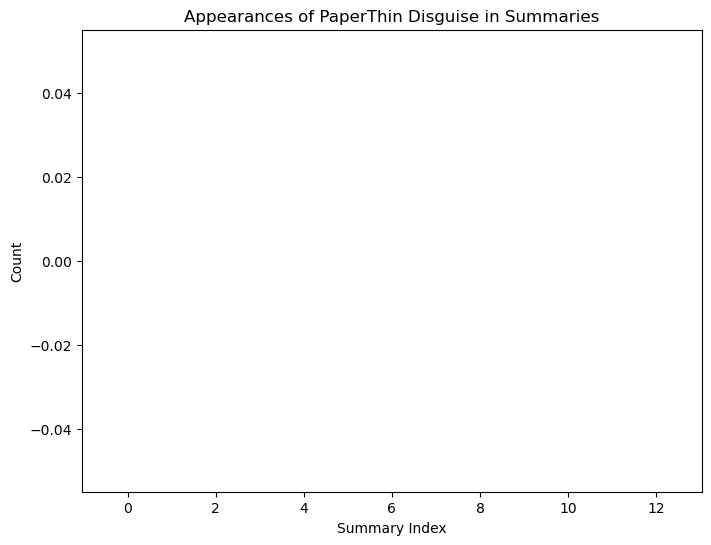

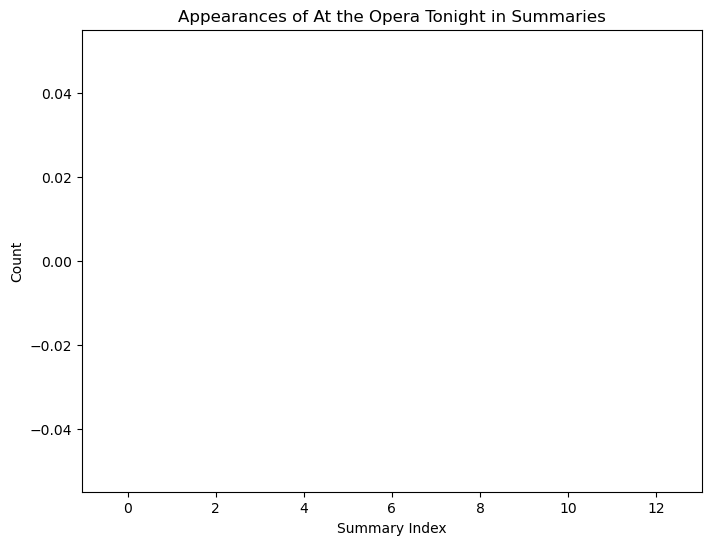

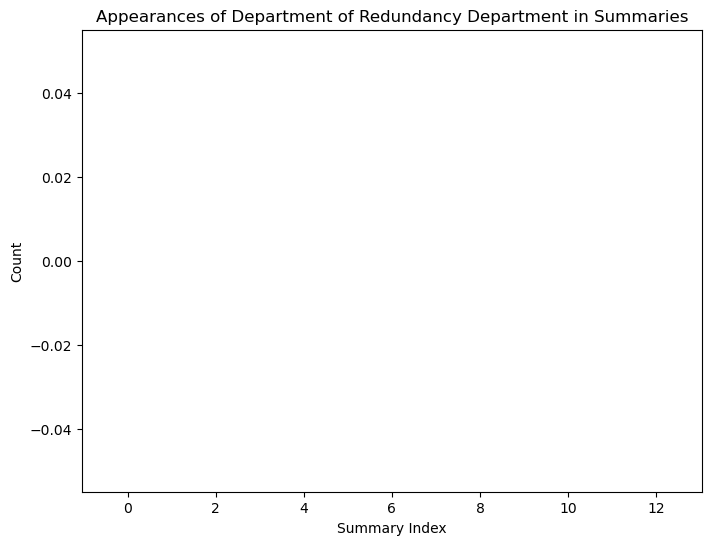

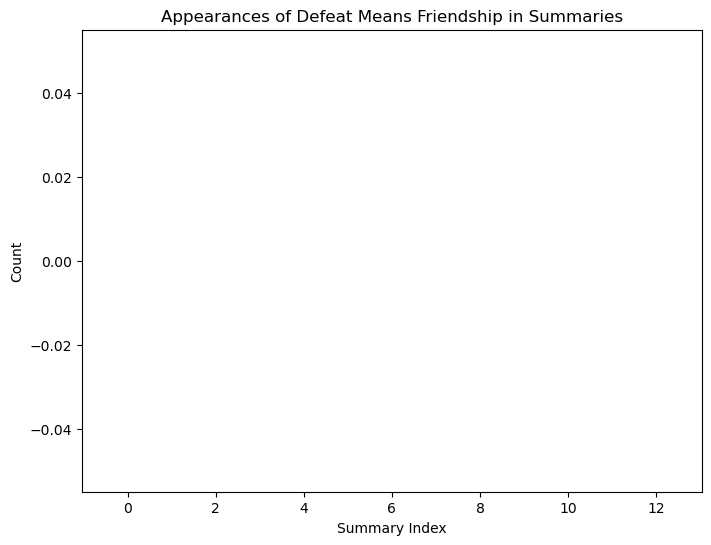

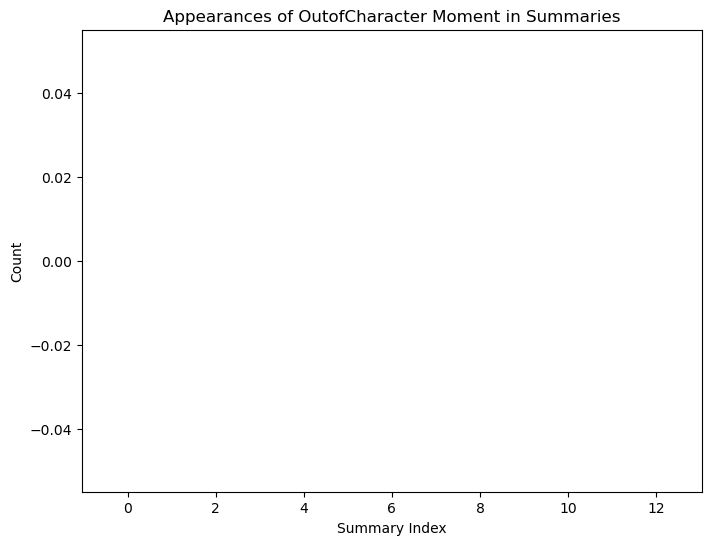

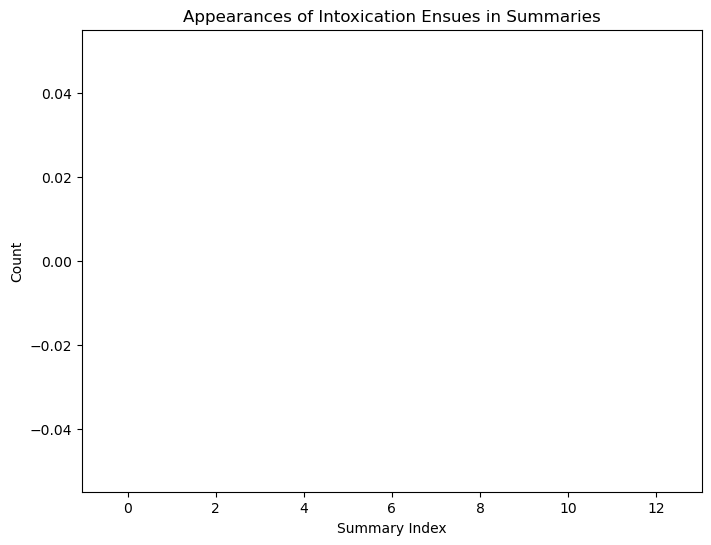

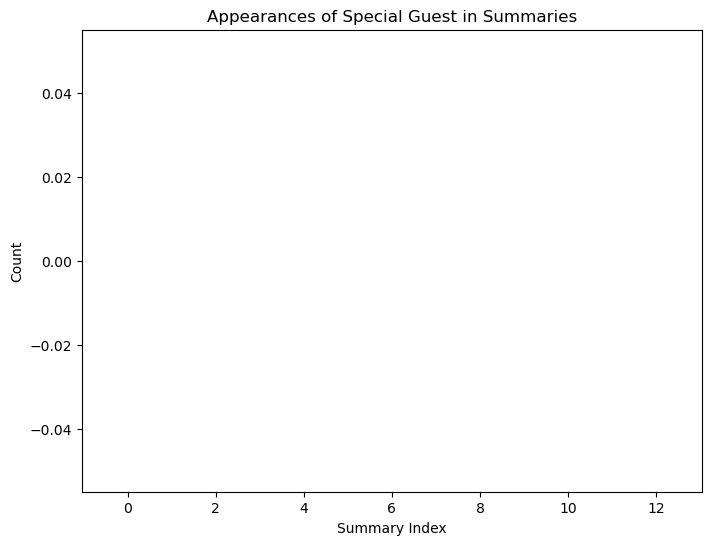

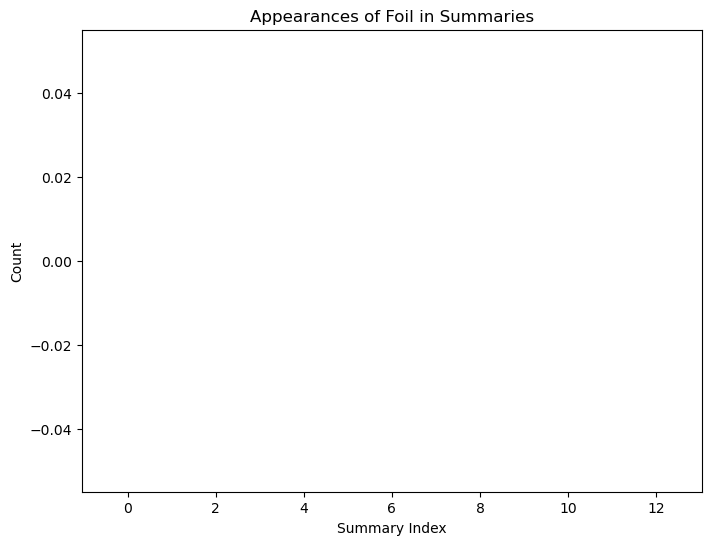

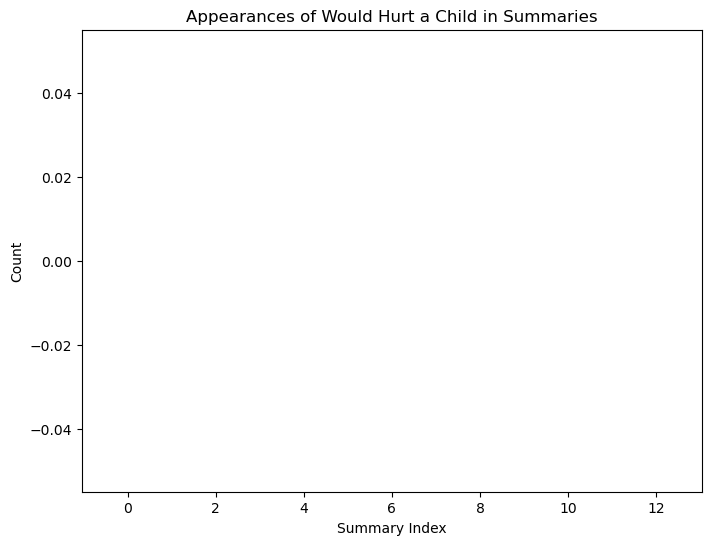

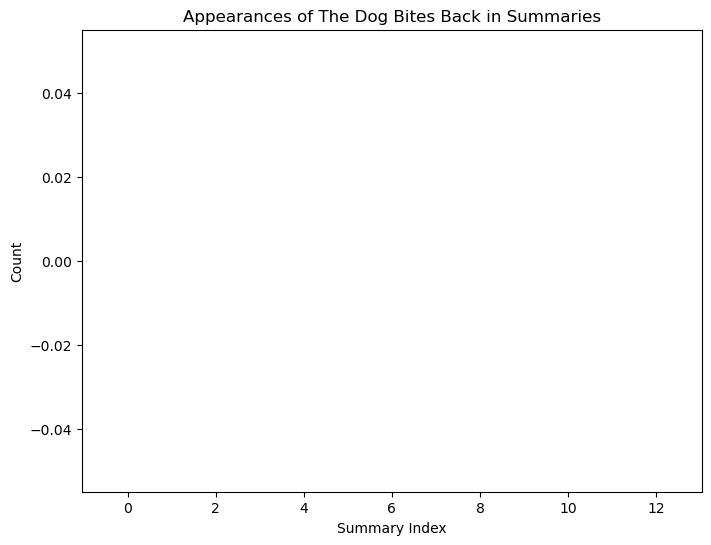

In [51]:
# Iterate through each trope and create a bar chart
for trope in tropes_to_analyze:
    plt.figure(figsize=(8, 6))  # Set the figure size for the plot
    plt.bar(training_df_copy.index, training_df_copy[f'{trope} Appearances'])
    plt.title(f'Appearances of {trope} in Summaries')
    plt.xlabel('Summary Index')
    plt.ylabel('Count')
    plt.show()

## A. Test data set-up

Now every model needs to be tested and for this instance, I chose the first season of the Avatar: The Last Airbender as my choice of test data. It's almost similar in structure for both its wiki and the recap pages.

In [52]:
# base wiki url for testing

test_wiki_url = 'https://avatar.fandom.com/wiki/'

In [53]:
#checking to see if site is up

response = requests.get(test_wiki_url)
print(response)

<Response [200]>


In [54]:
# list of avatar's seasons to scrape

test_seasons_list = ['Category:Book One: Water']

In [55]:
# List of episode URLs to scrape
test_episode_urls = []

for season in test_seasons_list:
    url = test_wiki_url + season  # Use test_wiki_url here
    response = requests.get(url)
    if response.status_code == 200:
        html_code = response.text
        soup = BeautifulSoup(html_code, 'html.parser')

        # Find all the <a> tags with the specified class
        a_tags = soup.find_all('a', class_='category-page__member-link')

        # Extract the href from the <a> tags and store them in test_episode_urls
        for a_tag in a_tags:
            test_episode_url = a_tag['href']
            test_episode_urls.append(test_episode_url)

# Now you have a list of episode URLs to scrape
for episode_url in test_episode_urls:
    print(episode_url)

/wiki/The_Avatar_Returns
/wiki/Bato_of_the_Water_Tribe
/wiki/The_Blue_Spirit
/wiki/Category:Book_One:_Water_transcripts
/wiki/The_Boy_in_the_Iceberg
/wiki/The_Deserter
/wiki/The_Fortuneteller
/wiki/The_Great_Divide
/wiki/Imprisoned
/wiki/Jet_(episode)
/wiki/The_King_of_Omashu
/wiki/The_Northern_Air_Temple
/wiki/The_Siege_of_the_North,_Part_1
/wiki/The_Siege_of_the_North,_Part_2
/wiki/The_Southern_Air_Temple
/wiki/The_Storm
/wiki/The_Warriors_of_Kyoshi
/wiki/The_Waterbending_Master
/wiki/The_Waterbending_Scroll
/wiki/Winter_Solstice,_Part_1:_The_Spirit_World
/wiki/Winter_Solstice,_Part_2:_Avatar_Roku


Again, just like the simpsons wiki, the avatar urls have that /wiki/ in front of every url. Let's drop it.

In [56]:
test_episode_urls = [x[6:] for x in test_episode_urls]
test_episode_urls

['The_Avatar_Returns',
 'Bato_of_the_Water_Tribe',
 'The_Blue_Spirit',
 'Category:Book_One:_Water_transcripts',
 'The_Boy_in_the_Iceberg',
 'The_Deserter',
 'The_Fortuneteller',
 'The_Great_Divide',
 'Imprisoned',
 'Jet_(episode)',
 'The_King_of_Omashu',
 'The_Northern_Air_Temple',
 'The_Siege_of_the_North,_Part_1',
 'The_Siege_of_the_North,_Part_2',
 'The_Southern_Air_Temple',
 'The_Storm',
 'The_Warriors_of_Kyoshi',
 'The_Waterbending_Master',
 'The_Waterbending_Scroll',
 'Winter_Solstice,_Part_1:_The_Spirit_World',
 'Winter_Solstice,_Part_2:_Avatar_Roku']

Oh. It appears there's a page that shouldn't be here. Let's remove it.

In [57]:
# Filter out URLs with the word "transcripts"
filtered_episodes_urls = [url for url in test_episode_urls if "transcripts" not in url]

# Now you have a clean list of episode URLs
for episode_url in filtered_episodes_urls:
    print(episode_url)

The_Avatar_Returns
Bato_of_the_Water_Tribe
The_Blue_Spirit
The_Boy_in_the_Iceberg
The_Deserter
The_Fortuneteller
The_Great_Divide
Imprisoned
Jet_(episode)
The_King_of_Omashu
The_Northern_Air_Temple
The_Siege_of_the_North,_Part_1
The_Siege_of_the_North,_Part_2
The_Southern_Air_Temple
The_Storm
The_Warriors_of_Kyoshi
The_Waterbending_Master
The_Waterbending_Scroll
Winter_Solstice,_Part_1:_The_Spirit_World
Winter_Solstice,_Part_2:_Avatar_Roku


Since we already defined a cleaner when we cleaned the simpsons wiki, we can reuse it for these episodes.

In [58]:
test_episode_url = ['The Avatar Returns']  # Replace 'The_Boy_in_the_Iceberg' with the desired episode URL

In [59]:
# Initialize lists to store episode information
episode_list = []
full_story = []

for episode in test_episode_url:  # Use the test_episode_url list
    url = wiki_url + episode
    response = requests.get(url)

    if response.status_code == 200:
        try:
            soup = BeautifulSoup(response.text, 'html.parser')

            # Find all <h2> elements on the page
            section_headings = soup.find_all("h2")

            # Initialize episode_title and full_text
            episode_title = ''
            full_text = ''

            # Set flags for start and end headings
            start_heading = "Synopsis"
            end_heading = "Credits"

            # Get the contents
            for heading in section_headings:
                text = scrape_clean(heading)

                if not episode_title and text:
                    episode_title = text
                    episode_list.append(episode_title)
                    print(episode_title)

                if text == start_heading:
                    # We are at the "Synopsis" section
                    paragraphs = heading.find_all_next("p")

                    for paragraph in paragraphs:
                        paragraph_text = scrape_clean(paragraph)

                        if paragraph.find("h2") and text == end_heading:
                            # We have reached the "Credits" section, so stop
                            break

                        if len(paragraph_text) > 0:
                            full_text += ''.join(paragraph_text)

            full_story.append(full_text)

        except Exception as e:
            print(f"Error occurred while processing episode: {episode}\nError: {str(e)}")
    else:
        print(f"Failed to retrieve data for episode: {episode}")

# Create a dictionary to map episode titles to their respective text
wiki_text = {}
for key, value in zip(episode_list, full_story):
    wiki_text[key] = value

Failed to retrieve data for episode: The Avatar Returns
